M57965.2
GATCTATCTGGTCCAGACCATCCTTTGAACCAAGTGGACTTAGTGGGGCTGAAGGAGGTGTGGGGACAAAGAACCTATGGCAGGGCAACCGGCCCTCCTGTCTGCAGCCTGGCTTCCTCAATTTTGTGTTCCTAACCTAAGAGCTGCCATTCAGTGAGGGCCCACAGTGTGTCTGCTGTGTGTAGACTCTGCTTGTGCAATCTCTAATGGCCTGAGTAGCCCTGGAAACAAAATGTGGCTATCCCCATGTTACAGATGACAAAACTGGCTCAAAGCAATTATATGACTGACGTAGACCACACAGCTAGAAAATGGAATCACTGGGTTTCAAAGTGGATTTTTGTGACTGACTCCAAAGCTGACCAGAGTGCTCATCCTGTATGCTTCTGAGGCCTCTGGCCCTCCAGACCGGTCACTCCCCACAAAGTCTCCCTTTTGGTGAGTTGTGTCCCTCCAAACACTCCCTGAAGGCAAGATCAACCTGCCCTAACTACCCCAAAGTGAACTAGGCCAGCCCCAAGCCTGTCTCCGGCCCTCCATCTCTCTCTTTGTTCACATCCATCAGAAAGCAGAGACCTAGAGTAGGGAATGAGAGGGGGTGCACAAGTACAAAAGATTTTGAAGCAGCAGGAAGACGAAAGAAGTACAAGAAGGAGCAGCTGTTTGTAAAAGGGAAAATCTGAGACAGGCAGAAAGCTCAGCTCCCTAATCCTAGGCTCGTGTGGAGCCAGGGCAGGGTCCCCCAAGGTCAGGGATTCTGGGGGCAGGCGGATGGGAGAGTCAGCCTCCACTCCTGGGTGGCTCCCCTCTGCCCTGTGCACAAACAACGAGTGCCTCATTCCTCCCCTGCACCAAGTGCCCTGCCTCTTCCTGCCCCGTTTCTTCCTTCCCTTTGGGTACCGGATCTTTTTTCTGATTCCCCTCTCTCCATGCTGACATCGCTTCTAATTCGCCCTGGTGTCTCCCTCCCTCACAATTACTGGGAGTAATT

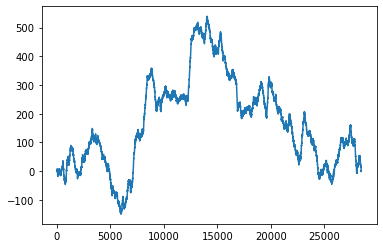

In [2]:
from Bio import SeqIO
from numba import jit
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def modlin(x,a,b):
    return a*x+b

for seq_record in SeqIO.parse("HUMBMYH7.gb","genbank"): #"HHUMHBB.gb","genbank"
    print(seq_record.id)
    print(seq_record.seq)
    print(len(seq_record.seq))
u=[0]
st=str(seq_record.seq)
for s in st:
    if s in ['A','G','H','X']:
        u.append(u[-1]-1.)
    else:
        u.append(u[-1]+1.)

Values=np.array(u)
Values-=np.mean(Values[1:]-Values[:-1])*np.arange(1,len(Values)+1)
Dates=np.arange(1,len(Values)+1)

plt.plot(Dates,Values)
plt.show()


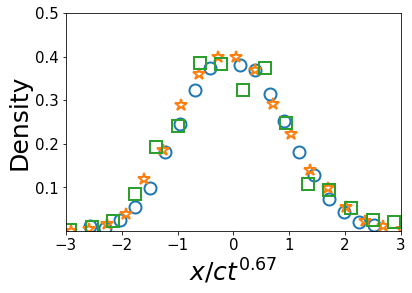

In [5]:
from scipy.stats import norm
i=0
Marker=['o','*','s','p']

H=0.67
for t in [20,40,80]:
    X=[]
    for ini in range(0,len(Values)-t):
        x0=Values[ini]
        X.append(Values[ini+t]-x0)
    h,bins=np.histogram(np.array(X)/t**H,density=True,bins=20)
    bins=(bins[1:]+bins[:-1])/2
    plt.plot(bins,h,Marker[i],markersize=12,linestyle='',fillstyle='none',linewidth=20,markeredgewidth=2.0)
    i+=1
#Xl=np.linspace(-4,4,1000)
#plt.plot(Xl,norm.pdf(Xl,0,1),'--k',linewidth=2)
plt.ylim(1e-3,0.5)
plt.xlim(-3,3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$x/ct^{0.67}$',fontsize=25)
plt.ylabel('Density',fontsize=25)
#plt.semilogy()
plt.savefig('DNA_HUMBMYH7.svg')
plt.show()    

71


/tmp/ipykernel_27172/1481982115.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Tn=np.array([np.array(t) for t in Tn])


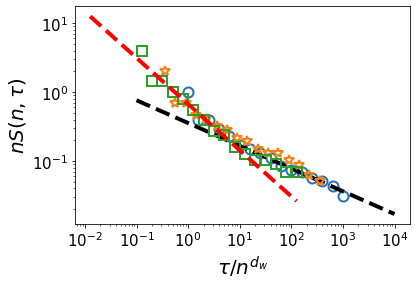

In [6]:
H=0.67

from numba import jit
@jit(nopython=True)
def tau(V):
    T=[]
    M=V[0]
    tau=1
    for k in range(1,len(V)-1):
        if V[k]>M:
            T.append(tau)
            tau=1
        else:
            tau+=1
        M=max(V[k],M)
    return T

T=[]
epochs=400
print(len(Values)//epochs)
for k in range(0,len(Values)-2000,len(Values)//epochs):
  T.append(tau(Values[k:]))


@jit(nopython=True)
def FreCum(T,Tl):
    S=[]
    for t in Tl:
        S.append(np.sum(T>=t)/len(T))
    return S

Tn=T[:]
Tn=np.array([np.array(t) for t in Tn])



theta=1-H

dw=1/H

N=[1,2,4]
Marker=['o','*','s']
i=-1
for n in N:
    i+=1
    LT=[]
    for t in Tn:
      if len(t)>4:
        LT.append(t)
    Times=np.logspace(0,3,16)
    Ti=[LT[k][n] for k in range(len(LT))]
    Ti=np.array(Ti)
    Ti=Ti[Ti>0]
    Sl=np.array([np.sum(Ti>=ti)/len(Ti) for ti in Times])
    n0=n
    #plt.plot(Times,Sl,'o',markersize=5,linestyle='',fillstyle='none',linewidth=20,markeredgewidth=2.0)
    plt.plot(Times/n0**dw,Sl*n0,Marker[i],markersize=10,linestyle='',fillstyle='none',linewidth=20,markeredgewidth=2.0)
    if n==N[-1]:
      Ti=np.logspace(-1,3,41)
      plt.plot(Ti/n0**dw,(Ti/Times[len(Times)//4])**(-H)*Sl[len(Times)//4]*n0,'--r',linewidth=4)
    if n==N[0]:
      Ti=np.logspace(-1,4,41)  
      plt.plot(Ti/n0**dw,(Ti/Times[len(Times)//4*3])**(-theta)*Sl[len(Times)//4*3]*n0,'--k',linewidth=4)

plt.xlabel(r'$\tau/n^{d_w}$',fontsize=20)
plt.ylabel(r'$nS(n,\tau)$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.semilogx()
plt.semilogy()

plt.savefig('Records_HUMBMYH7.svg')